<b>1. Tree-Based Methods</b>

(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test
set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [56]:
!pip install imblearn

In [57]:
!pip install scikit-learn

In [58]:
!python3 -m pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import os
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from astropy.stats import bootstrap
import statistics
from numpy import mean
from numpy import median
from numpy import percentile
import scipy as sp
import scipy.stats
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn import tree, metrics, model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv('../data/aps_failure_training_set.csv',skiprows=20)
test_data = pd.read_csv('../data/aps_failure_test_set.csv',skiprows=20)
train_data=train_data.replace('na',np.nan)
test_data=test_data.replace('na',np.nan)

x_train = train_data.iloc[:,1:]
y_train = train_data['class']
x_test = test_data.iloc[:,1:]
y_test = test_data['class']

(b) Data Preparation

This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea.

In reality, when we have a model and we want to fill in missing values, we do not have access to training data, so we only use the statistics of test data to fill in the missing values.

i. Research what types of techniques are usually used for dealing with data with missing values(They are called data imputation techniques). Pick at least one of them and apply it to this data in the next steps.(You are welcome to test more than one method.)

reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/

Listwise or case deletion: simply omit those cases with the missing data and analyze the remaining data.

Pairwise deletion: eliminates information only when the particular data-point needed to test a particular assumption is missing.

Mean substitution: the mean value of a variable is used in place of the missing data value for that same variable.

Regression imputation: preserves all cases by replacing the missing data with a probable value estimated by other available information.

In [35]:
imp = SimpleImputer(missing_values=np.nan,strategy="mean")
imp.fit(x_train)
x_train = pd.DataFrame(imp.transform(x_train))
imp.fit(x_test)
x_test = pd.DataFrame(imp.transform(x_test))

column_names = x_train.columns
x_train = pd.DataFrame(x_train, columns=column_names)
x_test = pd.DataFrame(x_test, columns=column_names)

y_train = y_train.apply(lambda x: 0 if x=='neg' else 1)
y_test = y_test.apply(lambda x: 0 if x=='neg' else 1)

x_train

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


ii. For each of the 170 features, calculate the coefficient of variation CV = ms , where s is sample standard deviation and m is sample mean.

In [36]:
cv = x_train.std()/x_train.mean()
cv = pd.DataFrame(cv, columns=["CV"])
cv

,CV
0,2.450938
1,2.328400
2,2.169767
3,183.847620
4,23.190937
...,...
165,4.962483
166,3.222010
167,5.626979
168,47.124953


iii. Plot a correlation matrix for your features using pandas or any other tool.

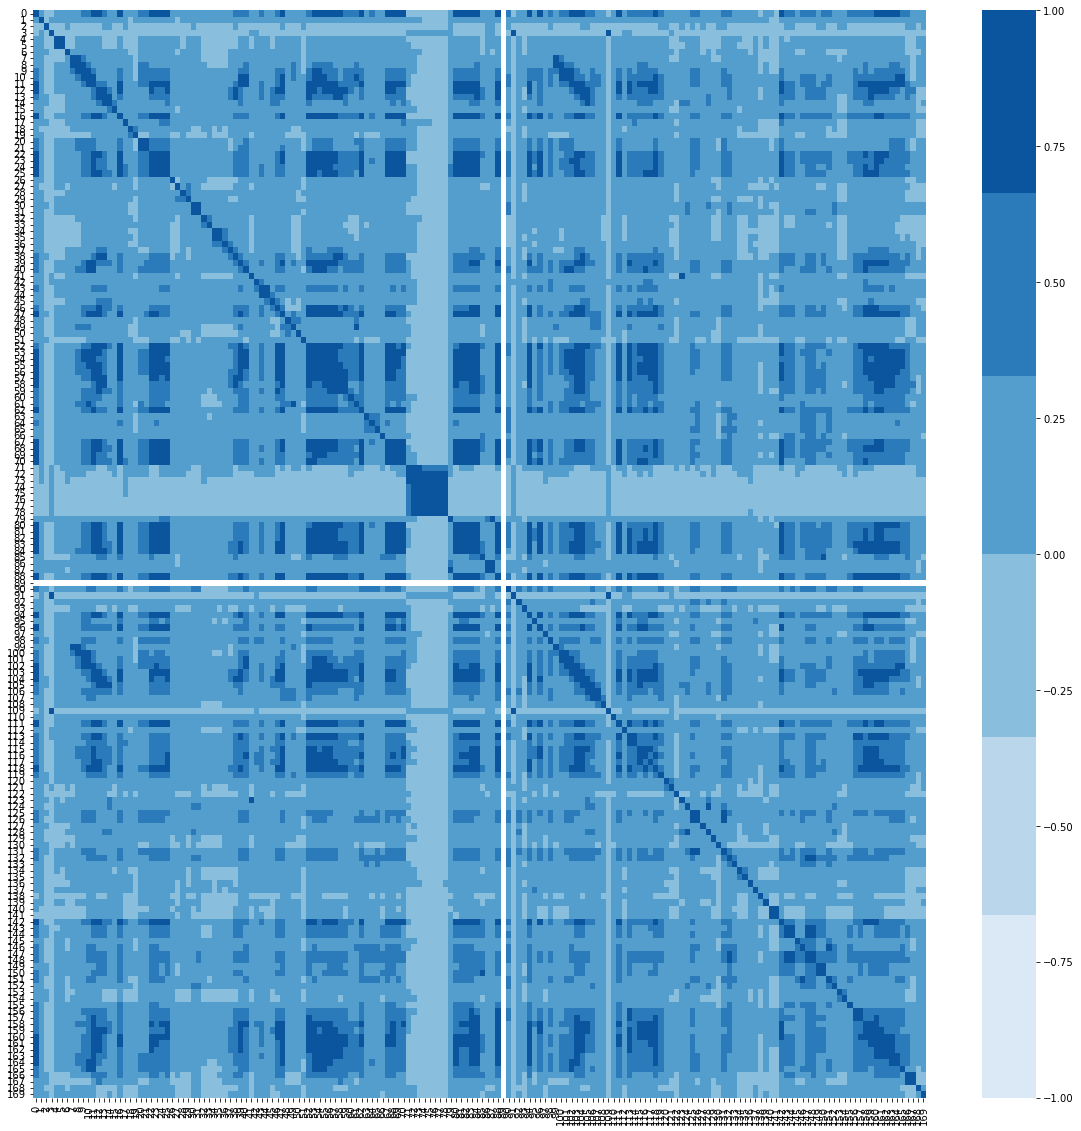

In [37]:
correlation = x_train.corr()
ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, cmap=sns.color_palette("Blues"), xticklabels=correlation.columns, yticklabels=correlation.columns)

iv. Pick ⌊ squareroot(170)⌋ features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [38]:
threshold = math.floor(pow(170,0.5)) # 13
print('{} features with highest CV'.format(threshold))
sortedCV = cv.sort_values('CV', ascending=False)
features = sortedCV[:threshold].T
train_features = x_train.iloc[:, features.columns] # features.columns are index of the features.
train_features

13 features with highest CV


,122,91,109,3,136,138,6,27,41,51,19,29,93
0,0.0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000443
2,0.0,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.000000,224.000000,186.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59996,0.0,2.000000,0.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59997,0.0,2.000000,0.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59998,0.0,2.000000,580.000000,494.000000,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


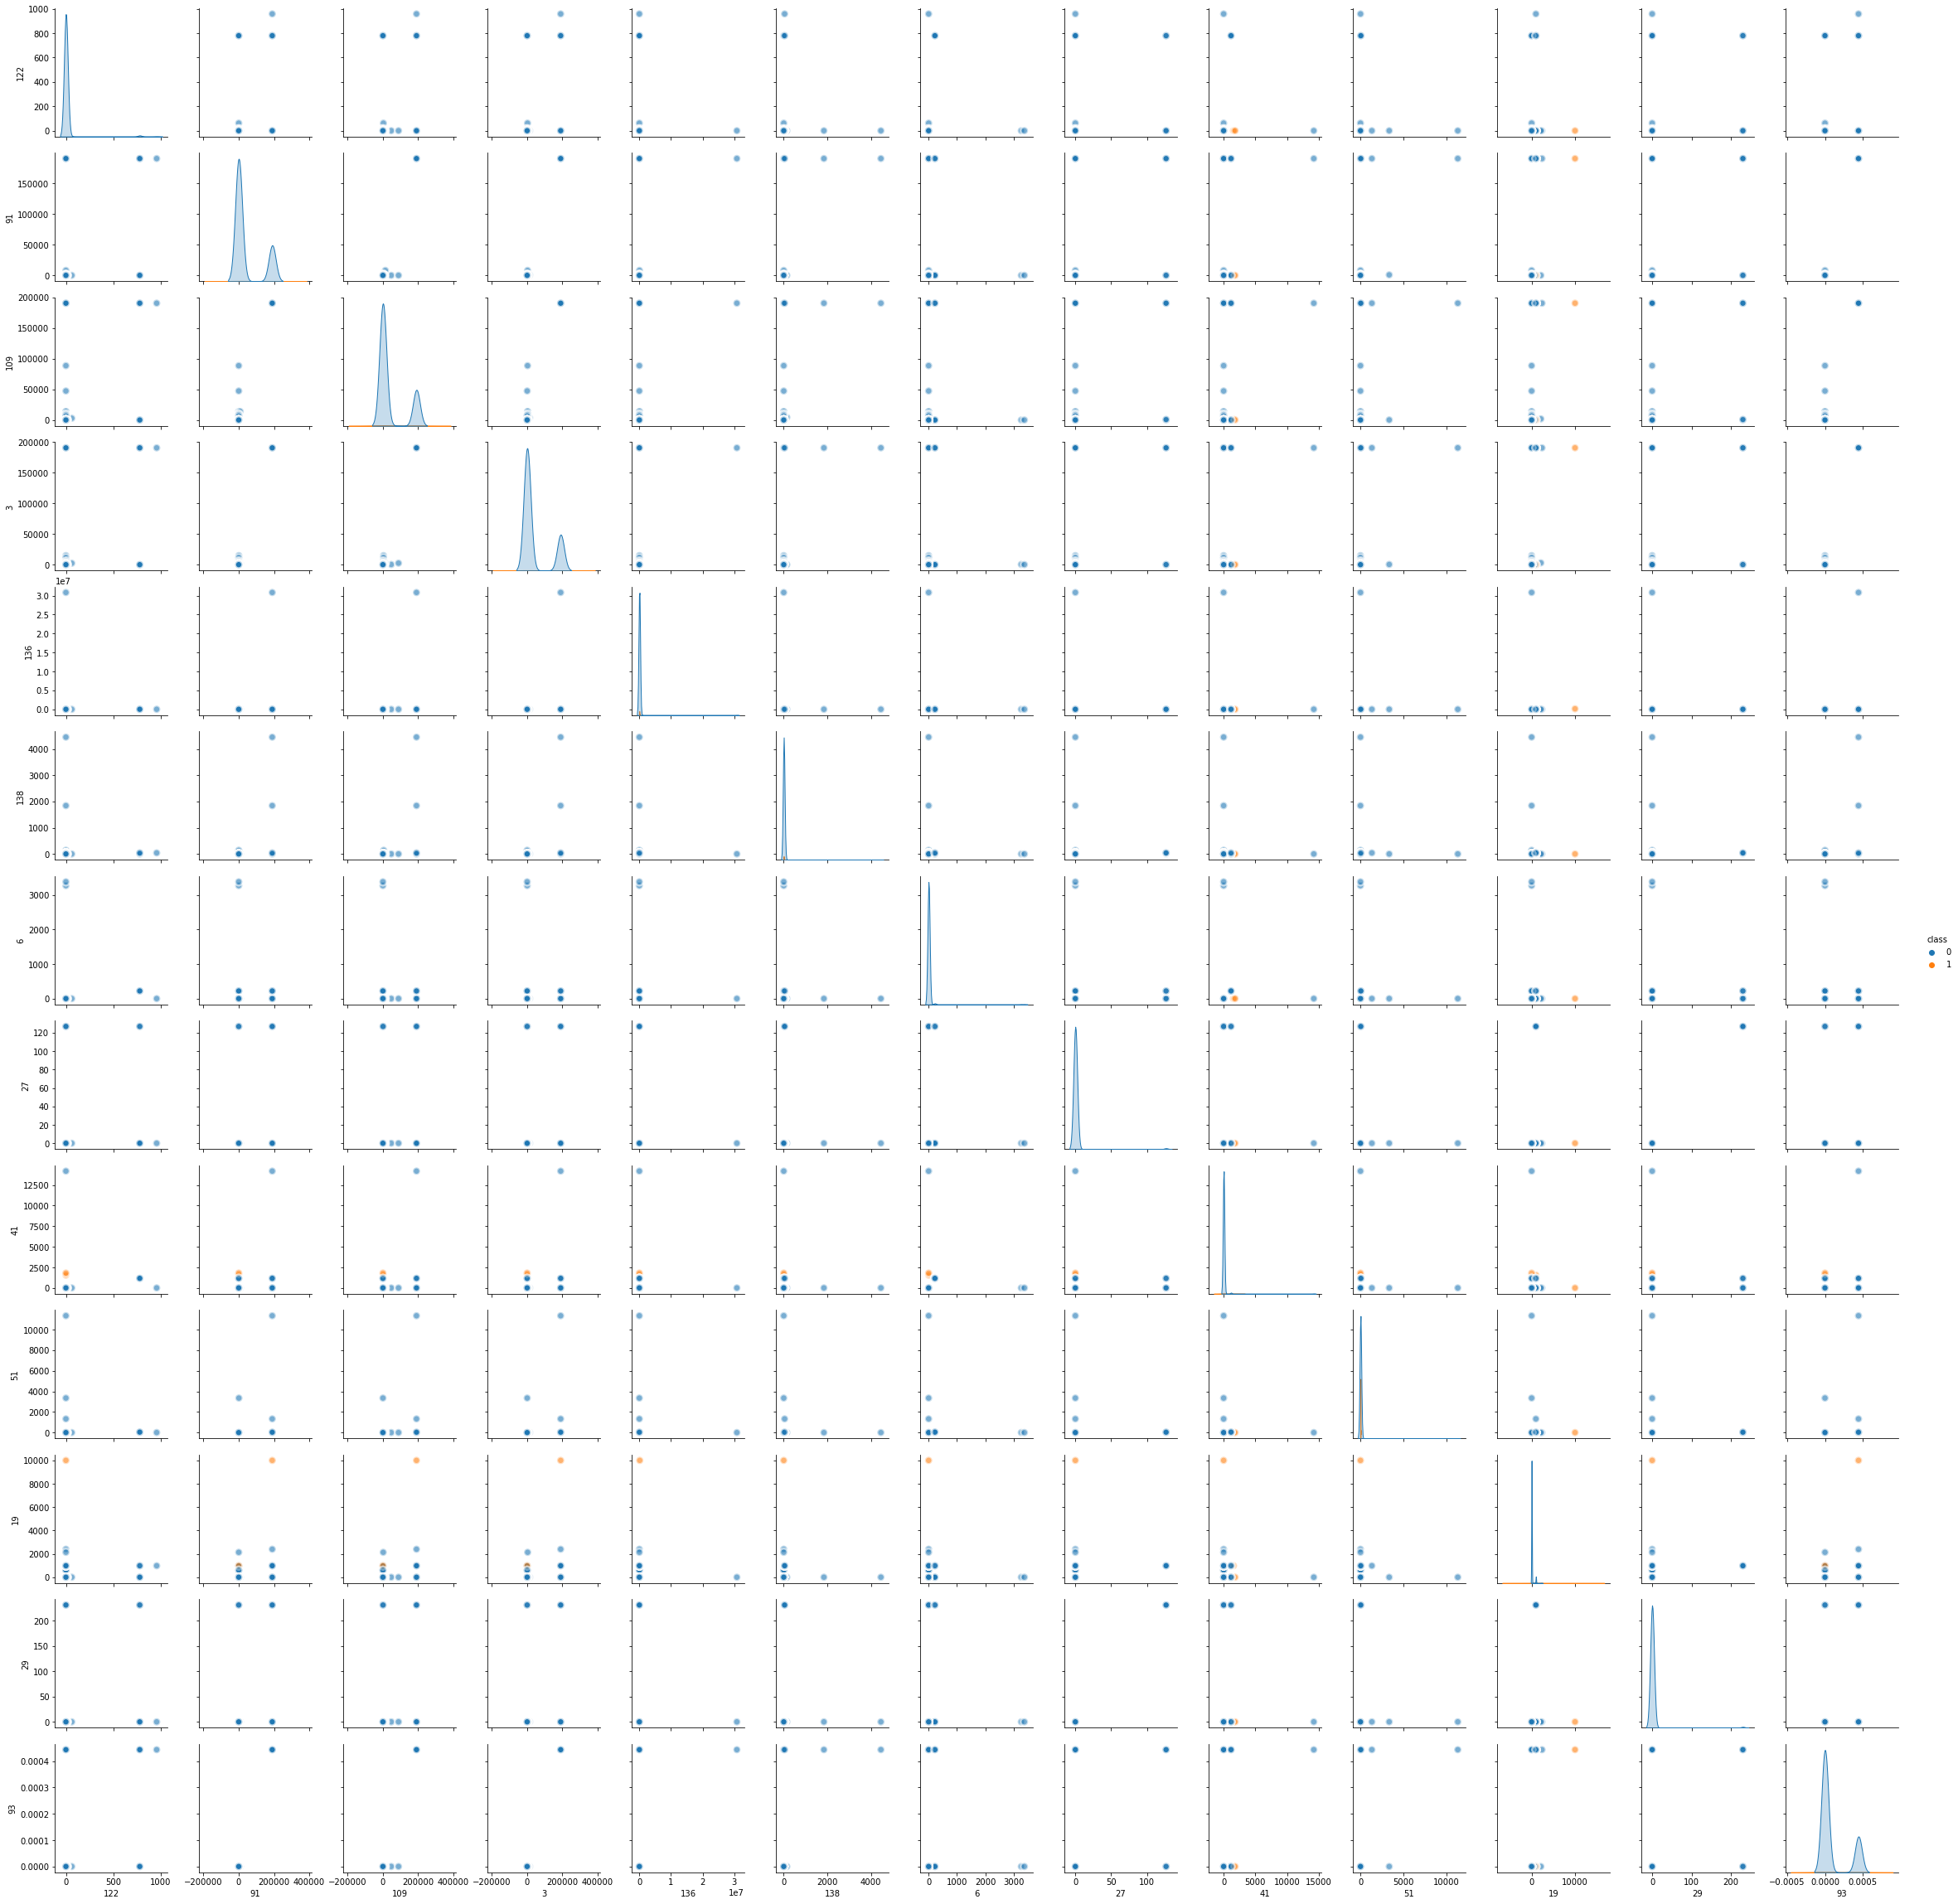

In [65]:
train_features['class'] = y_train
sns.pairplot(train_features.sample(1000), plot_kws=dict(s=80, edgecolor="white", linewidth=2.5, alpha=0.6), hue="class")
plt.show()

It is hard to draw any conclusions about significance of these features just by the scatter plots.

Below are the box plots.

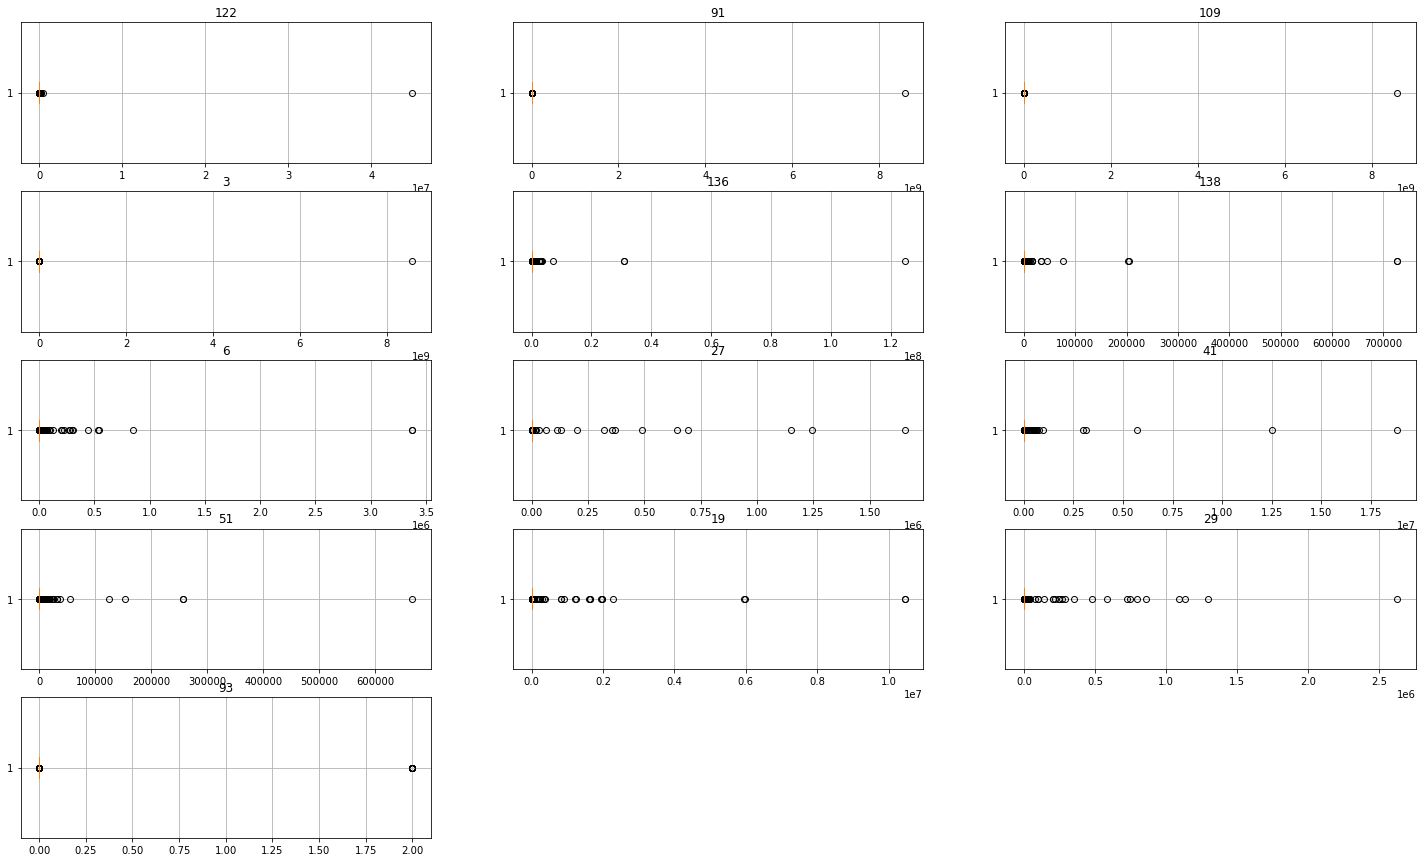

In [41]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(25, 15))
indexes = [122, 91, 109, 3, 136, 138, 6, 27, 41, 51, 19, 29, 93]
index = 0
for a in range(0, 5):
    for b in range(0, 3):
        if index < 13:
            ax[a, b].boxplot(train_features.loc[:, indexes[index]], whis=2, vert=False)
            ax[a, b].grid(True)
            ax[a, b].title.set_text(indexes[index])
            b, index = b + 1, index + 1

ax[4, 1].remove()
ax[4, 2].remove()
plt.show()

v. Determine the number of positive and negative data. Is this data set imbalanced?

In [67]:
print("Train Data: ")
print(y_train.value_counts())
print("Test Data: ")
print(y_test.value_counts())

Train Data: 
0    59000
1     1000
Name: class, dtype: int64
Test Data: 
0    15625
1      375
Name: class, dtype: int64


Obviously, it is imbalanced.

(c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

For test data:


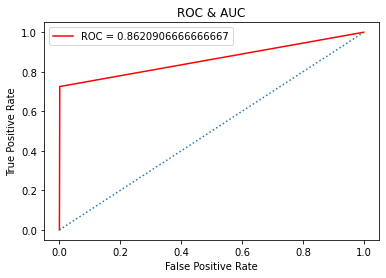

Train Data Confusion Matrix:
[[15607    18]
 [  103   272]]
F1-Score: 0.8180451127819548
Misclassification rate is: 0.0075625000000000275
Out of Bag error is: 0.0061833333333333185


In [68]:
print("For test data:")
randForestClf = RandomForestClassifier(n_estimators=50, random_state=2, oob_score=True)
randForestClf.fit(x_train, y_train)
y_pred = randForestClf.predict(x_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
print('Train Data Confusion Matrix:')
print(confusionMatrix)
# calculate f1-score
print('F1-Score:', f1_score(y_test, y_pred))
# calculate misclassification rate
print('Misclassification rate is:', 1-randForestClf.score(x_test, y_test))
# calculate out of bag error
print('Out of Bag error is:', 1-randForestClf.oob_score_)

For train data:


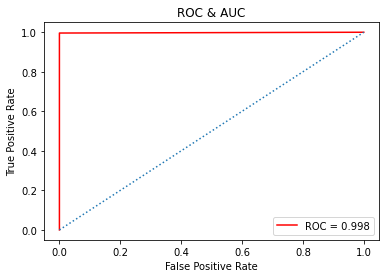

Train Data Confusion Matrix:
[[59000     0]
 [    4   996]]
F1-Score: 0.9979959919839679
Misclassification rate is: 6.666666666665932e-05
Out of Bag error is: 0.0061833333333333185


In [69]:
print("For train data:")
y_pred = randForestClf.predict(x_train)

fpr, tpr, threshold = roc_curve(y_train, y_pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_train, y_pred)
print('Train Data Confusion Matrix:')
print(confusionMatrix)
# calculate f1-score
print('F1-Score:', f1_score(y_train, y_pred))
# calculate misclassification rate
print('Misclassification rate is:', 1-randForestClf.score(x_train, y_train))
# calculate out of bag error
print('Out of Bag error is:', 1-randForestClf.oob_score_)

Train set has a smaller oob error than test set.

(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

For train data:


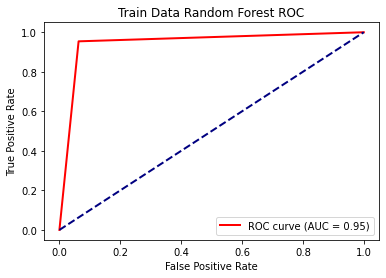

Train Data Confusion Matrix:
[[55283  3717]
 [ 2713 56287]]
F1-Score: 0.9459682027494875
Misclassification rate is: 0.054491525423728815
Out of Bag error is: 0.05421186440677961


In [70]:
# some research on how class imbalance is addressed in random forests: 
# https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

sm = SMOTE()
smote_x_train, smote_y_train = sm.fit_resample(x_train, y_train)

# build Random Forest Classifier
clf = RandomForestClassifier(n_estimators=50, max_depth=2,oob_score=True)
clf.fit(smote_x_train, smote_y_train)

print("For train data:")
y_train_predict = clf.predict(smote_x_train)

# draw ROC and AUC
fpr, tpr, threshold = roc_curve(smote_y_train, y_train_predict)
# cal AUC value
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Data Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(smote_y_train, y_train_predict)
print('Train Data Confusion Matrix:')
print(confusionMatrix)
# calculate f1-score
print('F1-Score:', f1_score(smote_y_train, y_train_predict))
# calculate misclassification rate
print('Misclassification rate is:', 1-clf.score(smote_x_train, smote_y_train))
# calculate out of bag error
print('Out of Bag error is:', 1-clf.oob_score_)

For test data:


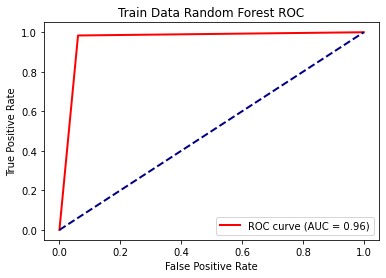

Train Data Confusion Matrix:
[[14670   955]
 [  256 15369]]
F1-Score: 0.9620958402453912
Misclassification rate is: 0.03875200000000001
Out of Bag error is: 0.05421186440677961


In [71]:
print("For test data:")
smote_x_test, smote_y_test = sm.fit_resample(x_test, y_test)
y_test_predict = clf.predict(smote_x_test)

# draw ROC and AUC
fpr, tpr, threshold = roc_curve(smote_y_test, y_test_predict)
# cal AUC value
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Data Random Forest ROC')
plt.legend(loc="lower right")
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(smote_y_test, y_test_predict)
print('Train Data Confusion Matrix:')
print(confusionMatrix)
# calculate f1-score
print('F1-Score:', f1_score(smote_y_test, y_test_predict))
# calculate misclassification rate
print('Misclassification rate is:', 1-clf.score(smote_x_test, smote_y_test))
# calculate out of bag error
print('Out of Bag error is:', 1-clf.oob_score_)

After using SMOTE resampling, for test data, the F1-score has increased from 0.82 to 0.96, and the misclassification rate has decreased. For train data, it is the opposite, but overall, the model performs better.

(e) XGBoost and Model Trees

In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has 􏰀j βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [5]:
# convert to xgb matrix
train_data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)
test_data_dmatrix = xgb.DMatrix(data=x_test, label=y_test)
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10]

In [6]:
RMSE = list()
for a in alphas:
    params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': a} # binary:logitraw
    cv_results = xgb.cv(dtrain=train_data_dmatrix, params=params, nfold=5, num_boost_round=25, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)
    RMSE.append(cv_results["test-rmse-mean"].tail(1).tolist()[0])
best = alphas[RMSE.index(min(RMSE))]
print('Best alpha:', best)

xg_reg = xgb.XGBRegressor(objective='binary:logistic', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=best, n_estimators=25)
xg_reg.fit(x_train, y_train)

Best alpha: 0.01
[20:36:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=25, n_jobs=8,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0.00999999978, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [74]:
pred = xg_reg.predict(x_test)
# pred = pred.apply(lambda x: 0 if x<0.5 else 1)
pred[pred>0.3] = 1
pred[pred<=0.3] = 0

MSE = mean_squared_error(y_test, pred)
# r_square = xg_reg.score(x_test, y_test)
print('MSE:', MSE)

MSE: 0.009125


For test data:


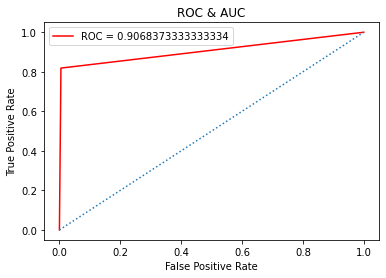

Train Data Confusion Matrix:
[[15547    78]
 [   68   307]]


In [75]:
print("For test data:")
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_test, pred)
print('Train Data Confusion Matrix:')
print(confusionMatrix)

For train data:


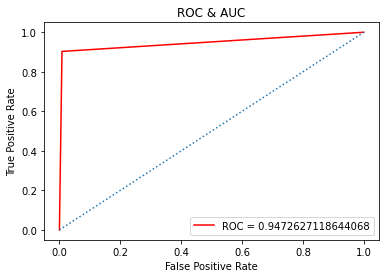

Train Data Confusion Matrix:
[[58500   500]
 [   97   903]]


In [76]:
print("For train data:")
pred = xg_reg.predict(x_train)
pred[pred>0.2] = 1
pred[pred<=0.2] = 0
fpr, tpr, threshold = roc_curve(y_train, pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_train, pred)
print('Train Data Confusion Matrix:')
print(confusionMatrix)

(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBosst with L1-penalized lo- gistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [77]:
from collections import Counter
# convert to xgb matrix
smote_x_train, smote_y_train = sm.fit_resample(x_train, y_train)
smote_x_test, smote_y_test = sm.fit_resample(x_test, y_test)
train_data_dmatrix = xgb.DMatrix(data=smote_x_train, label=y_train)
test_data_dmatrix = xgb.DMatrix(data=smote_x_test, label=y_test)
# print(y_test)
print(Counter(y_test))
# print(smote_y_test)
print(Counter(smote_y_test))
print(Counter(y_train))
print(Counter(smote_y_train))
print(max(x_train))
print(min(x_train))
print(max(smote_x_train))
print(min(smote_x_train))

Counter({0: 15625, 1: 375})
Counter({0: 15625, 1: 15625})
Counter({0: 59000, 1: 1000})
Counter({0: 59000, 1: 59000})
169
0
169
0


In [42]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10]
RMSE = list()
for a in alphas:
    params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': a} # binary:logitraw
    cv_results = xgb.cv(dtrain=train_data_dmatrix, params=params, nfold=5, num_boost_round=25, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)
    RMSE.append(cv_results["test-rmse-mean"].tail(1).tolist()[0])
best = alphas[RMSE.index(min(RMSE))]
print('Best alpha:', best)

Best alpha: 0.01


In [7]:
xg_reg = xgb.XGBRegressor(objective='binary:logistic', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=best, n_estimators=25)
# xg_reg.fit(smote_x_train, smote_y_train)
xg_reg.fit(x_train, y_train)

[20:37:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=25, n_jobs=8,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0.00999999978, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

MSE: 0.0165
For test data:


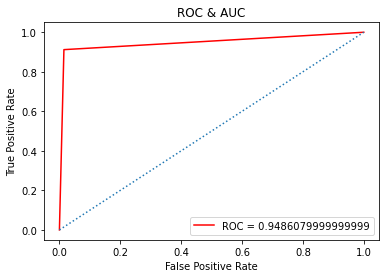

Confusion Matrix:
[[15394   231]
 [   33   342]]


In [9]:
pred = xg_reg.predict(x_test)
# pred = pred.apply(lambda x: 0 if x<0.5 else 1)
# print(Counter(pred))
pred[pred>0.15] = 1
pred[pred<=0.15] = 0
# print(Counter(pred))

MSE = mean_squared_error(y_test, pred)
# r_square = xg_reg.score(x_test, y_test)
print('MSE:', MSE)

print("For test data:")
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_test, pred)
print('Confusion Matrix:')
print(confusionMatrix)

For train data:


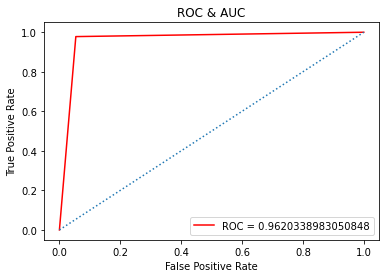

Confusion Matrix:
[[55818  3182]
 [   22   978]]


In [13]:
print("For train data:")
pred = xg_reg.predict(x_train)
pred[pred>0.05] = 1
pred[pred<=0.05] = 0
fpr, tpr, threshold = roc_curve(y_train, pred)
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='red', label='ROC = ' + str(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC & AUC')
plt.legend()
plt.show()

# calculate confusion matrix
confusionMatrix = confusion_matrix(y_train, pred)
print('Confusion Matrix:')
print(confusionMatrix)

Compared with e, SMOTE data gets a higher AUC score and accuracy, but it may take longer to run cuz the data size is bigger.

<b>2. ISLR 6.6.3</b>

a: iv. When we increase s, we removing the constraint we put on the coefficient. So the model becomes more flexible. So the training RSS will steadily decrease as the flexibility increase.

b: ii. When we increase s, the model becomes more flexible, so first decrease in test RSS then increase again in a  U shape.

c: iii. The variance will become higher when the flexibility increase.

d: iv. The bias decrease when the flexibility increase.

e: v. We can not decrease the irreducible error by increasing s.

<b>3. ISLR, 6.6.5</b>

In [43]:
from IPython.display import Latex

a: 

In [44]:
Latex("$(y_1-β̂_1*x_1-β̂_2*x_1)^2 + (y_2-β̂_1*x_2-β̂_2*x_2)^2 + λ(β̂^2_1 + β̂^2_2)$")

<IPython.core.display.Latex object>

b: 

In [45]:
Latex(r"$β̂_1(x^2_1 + x^2_2 + λ) + β̂_2(x^2_1 + x^2_2) = y_1x_1 + y_2x_2\\β̂_1(x^2_1 + x^2_2) + β̂_2(x^2_1 + x^2_2 + λ) = y_1x_1 + y_2x_2$")

<IPython.core.display.Latex object>

Changing positions, and we can get β̂1 = β̂2 from above.

c:

In [46]:
Latex("$(y_1-β̂_1*x_1-β̂_2*x_1)^2 + (y_2-β̂_1*x_2-β̂_2*x_2)^2 + λ(|β̂_1|+|β̂_2|)$")

<IPython.core.display.Latex object>

d: Simplify the formular

In [47]:
Latex("$2(y_1-(β̂_1+β̂_2)*x_1)^2 >=0 \\\β̂_1+β̂_2 = y_1/x_1 \\\ β̂_1+β̂_2 = s \; or\; β̂_1+β̂_2 = -s$")

<IPython.core.display.Latex object>

<b>4. ISLR 8.4.5</b>

(1) Majority vote approach: 6 prediction for Red, 4 for Green. So we classify x as Red. 

(2) Average probability: the average of 10 predictions is 0.45 which is < 0.5, so we classify x as Green.

<b>5. ISLR 9.7.3</b>

a: 

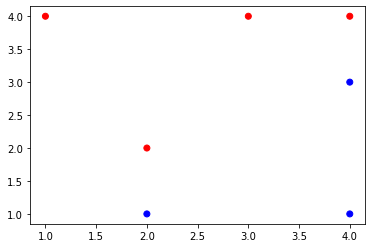

In [20]:
import matplotlib.pyplot as plt
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']
plt.figure()
plt.scatter(x1, x2, c = y)
plt.show()

b: The optimal separating hyperplane locates between (2,1)and(2,2), and between (4,3)and (4,4). Then we can obtain: x1-x2-0.5=0

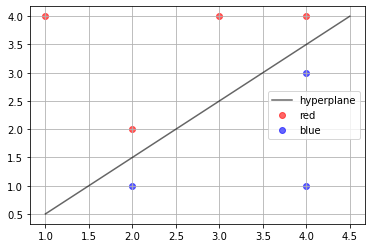

In [25]:
X = np.array([[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]])
y = np.array([1,1,1,1,0,0,0])
hyperplane_x = np.linspace(1, 4.5, 100)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label='red', alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label='blue',alpha=0.6)
plt.plot(hyperplane_x, hyperplane_x - 0.5, color="black", label='hyperplane',alpha=0.6);
plt.grid(True)
plt.legend()

c: The upper margin line will pass through (2,2) and (4,4), and the bottom margin will pass (2,1) and (4,3). So the upper margin equation is x1-x2=0, and the bottom line is x1-x2=1.

d: 

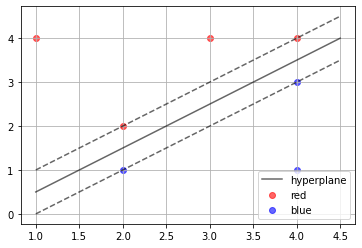

In [28]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label='red', alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label='blue',alpha=0.6)
plt.plot(hyperplane_x, hyperplane_x, color="black", linestyle='--',alpha=0.6);
plt.plot(hyperplane_x, hyperplane_x - 0.5, color="black", label='hyperplane',alpha=0.6);
plt.plot(hyperplane_x, hyperplane_x - 1, color="black", linestyle='--',alpha=0.6);
plt.grid(True)
plt.legend()

e: points (2,1), (2,2), (4,3) and (4,4).

f: a slight movement of the point(4,1) would not change the maximal margin hyperplane, because it is far from the hyperplane, and some red points are closer to the hyperplane.

g: hyperplane: x1-x2=0.2

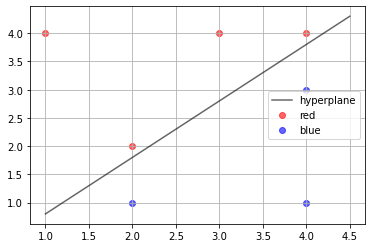

In [30]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label='red', alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label='blue',alpha=0.6)
plt.plot(hyperplane_x, hyperplane_x - 0.2, color="black", label='hyperplane',alpha=0.6);
plt.grid(True)
plt.legend()

h: An additional observation point at (3, 3).

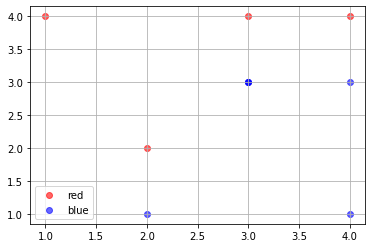

In [33]:
X = np.append(X, [[3,3]], axis = 0)
y = np.append(y, [0], axis= 0)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label='red', alpha=0.6)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label='blue',alpha=0.6)
plt.grid(True)
plt.legend()